In [1]:
# || Header ||
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from scipy import fftpack
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets
import ipyvolume as ipv
from skimage import measure
import linecache
import math
import random
import sys
sys.path.append('/home/andy/py_scripts/')
import set_fxns
import sm_fxns as sm
import dimer_dissoc_analysis as lib
import plot_dimer_diss as plt_lib
import dimer_cavity as cav_lib
from importlib import reload
#%matplotlib inline
#plt.rcParams.update({'font.size': 14})
#plt.rcParams['figure.facecolor'] = 'white'

In [2]:
eVtokT = 1/(8.617333262145e-5 * 120)
unitl = 21.9166090280612
fkjmol = 189.100159648419

In [3]:
def binDict(scalars, bond_dist, r0, r, dr):
    bins = np.round(np.arange(r0, r, dr) + dr/2, 3)
    my_dict = {}
    for i in bins:
        my_dict[str(i)] = []
    
    for i in range(len(scalars)):
        if bond_dist[i] < r0 or bond_dist[i] > r:
            continue
        else:
            my_ind = int((bond_dist[i]-r0)/dr)
            my_dict[str(np.round(r0+dr*my_ind+dr/2,3))] += [scalars[i]]
    
    return my_dict
def genDistr(my_array, spacing=0.1):
    low = int(min(my_array)/spacing)*spacing
    high = math.ceil(max(my_array)/spacing)*spacing
    bins = np.arange(low, high, spacing)
    counts = np.zeros([len(bins),3])
    
    for i in range(len(my_array)):
        counts[int((my_array[i]-low)/spacing),1] += 1
    norm = np.sum(counts[:,1])
    print(norm)
    counts[:,2] = np.sqrt((counts[:,1]/norm)*(1-counts[:,1]/norm)/norm)*1.96
    counts[:,1] /= norm
    counts[:,0] = bins + spacing/2
    
    return counts
def genFreeEnergy(pop_distr):
    e_distr = np.zeros([len(pop_distr),3])
    e_distr[:,0] = pop_distr[:,0]
    e_distr[:,1] = -np.log(pop_distr[:,1]/np.max(pop_distr[:,1]))/eVtokT
    my_ind = np.argwhere(pop_distr[:,1] == np.max(pop_distr[:,1]))[0][0]
    e_distr[:,2] = np.sqrt((pop_distr[:,2]/pop_distr[:,1])**2 + (pop_distr[my_ind,2]/pop_distr[my_ind,1])**2)/eVtokT
    return e_distr
def increasingBondDist(my_dir, tolerance = 0.1, r_stop = 9.0):
    bond_dist = np.loadtxt(my_dir+'/bondumb2.out')

    loc_max = bond_dist[0,1]
    my_ind = 0
    for i in range(1,len(bond_dist)):
        if bond_dist[i,1] > loc_max and bond_dist[i,1] < r_stop:
            loc_max = bond_dist[i,1]
            my_ind = i
        elif loc_max - bond_dist[i,1] > tolerance or bond_dist[i,1] > r_stop:
            break

    return bond_dist[:my_ind]

Purpose of notebook is to prepare figures for publication

In [4]:
# load the Na, Ar, e_com data for [3.6, 5.0], [5.0, 7.0], [7.0, 9.0] regions
na_fc = np.load('solvent_environments/gnd_eqb_na_fc.npy')
ar_fc = np.load('solvent_environments/gnd_eqb_ar_fc.npy')
e_com_fc = np.load('solvent_environments/gnd_eqb_ecom_fc.npy')

na_cage = np.load('solvent_environments/gnd_eqb_na_cage.npy')
ar_cage = np.load('solvent_environments/gnd_eqb_ar_cage.npy')
e_com_cage = np.load('solvent_environments/gnd_eqb_ecom_cage.npy')

na_loc = np.load('solvent_environments/gnd_eqb_na_loc.npy')
ar_loc = np.load('solvent_environments/gnd_eqb_ar_loc.npy')
e_com_loc = np.load('solvent_environments/gnd_eqb_ecom_loc.npy')

In [5]:
# counting number of Ar in the intramolecular region for ranges [3.6, 5.0], [5.0, 7.0]
r_cutoff = 3.0; kappa = 10

counts_intra1 = np.zeros(len(na_fc))
for i in range(len(na_fc)):
    closest_Ar = lib.closestAr(na_fc[i], ar_fc[i], n_cutoff=20, option='dimer') - na_fc[i,0,:]
    bond_ax = na_fc[i,1,:] - na_fc[i,0,:]
    bond_dist = np.sqrt(np.dot(bond_ax, bond_ax))
    bond_ax /= bond_dist
    
    axial_dist = np.dot(closest_Ar, bond_ax)
    radial_dist = np.sqrt(np.dot(closest_Ar, closest_Ar.T).diagonal() - axial_dist**2)
    
    radial_filter = 1/(np.exp(kappa*(radial_dist - r_cutoff)) + 1)
    axial_filter = 1/(np.exp(kappa*(np.abs(axial_dist-0.5*bond_dist)-0.5*bond_dist)) + 1)
    
    counts_intra1[i] = np.dot(radial_filter, axial_filter)

counts_intra2 = np.zeros(len(na_cage))
for i in range(len(na_cage)):
    closest_Ar = lib.closestAr(na_cage[i], ar_cage[i], n_cutoff=20, option='dimer') - na_cage[i,0,:]
    bond_ax = na_cage[i,1,:] - na_cage[i,0,:]
    bond_dist = np.sqrt(np.dot(bond_ax, bond_ax))
    bond_ax /= bond_dist
    
    axial_dist = np.dot(closest_Ar, bond_ax)
    radial_dist = np.sqrt(np.dot(closest_Ar, closest_Ar.T).diagonal() - axial_dist**2)
    
    radial_filter = 1/(np.exp(kappa*(radial_dist - r_cutoff)) + 1)
    axial_filter = 1/(np.exp(kappa*(np.abs(axial_dist-0.5*bond_dist)-0.5*bond_dist)) + 1)
    
    counts_intra2[i] = np.dot(radial_filter, axial_filter)

1329.0
1640.0
0.6280097817908201 1.4096036585365854


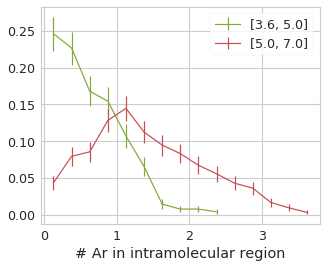

In [13]:
# integrate over cylinder r_cutoff = 3.0; kappa = 10
distr_intra1 = genDistr(counts_intra1, spacing=0.25)
distr_intra2 = genDistr(counts_intra2, spacing=0.25)

plt.figure(figsize=(5,4))
plt.errorbar(distr_intra1[:,0], distr_intra1[:,1], yerr=distr_intra1[:,2], color='C1', label='[3.6, 5.0]')
plt.errorbar(distr_intra2[:,0], distr_intra2[:,1], yerr=distr_intra2[:,2], color='C2', label='[5.0, 7.0]')
plt.xlabel('# Ar in intramolecular region')
plt.legend(loc=1)
print(np.dot(distr_intra1[:,0], distr_intra1[:,1]), np.dot(distr_intra2[:,0], distr_intra2[:,1]))

In [14]:
# radial distr fxn using radial distance and averaging over both Na's, loc
r0 = 0; r = 10; dr = 0.1
bins_radial_na = np.arange(r0,r,dr)
gr_loc = np.zeros([len(bins_radial_na),5])

for i in range(len(na_loc)):
    r_na1_ar = ar_loc[i] - np.repeat([na_loc[i,0]], repeats=1600, axis=0)
    r_na2_ar = ar_loc[i] - np.repeat([na_loc[i,1]], repeats=1600, axis=0)
    d_na1_ar = np.sqrt(r_na1_ar[:,0]**2 + r_na1_ar[:,1]**2 + r_na1_ar[:,2]**2)
    d_na2_ar = np.sqrt(r_na2_ar[:,0]**2 + r_na2_ar[:,1]**2 + r_na2_ar[:,2]**2)
    d_na_e = np.array([lib.dist(na_loc[i,0], e_com_loc[i]), lib.dist(na_loc[i,1], e_com_loc[i])])
    
    if d_na_e[0] < d_na_e[1]:
        for j in range(len(d_na1_ar)):
            if d_na1_ar[j] < r and d_na1_ar[j] > r0:
                my_ind = int((d_na1_ar[j]-r0)/dr)
                gr_loc[my_ind,1] += 1
            if d_na2_ar[j] < r and d_na2_ar[j] > r0:
                my_ind = int((d_na2_ar[j]-r0)/dr)
                gr_loc[my_ind,2] += 1
    else:
        for j in range(len(d_na1_ar)):
            if d_na1_ar[j] < r and d_na1_ar[j] > r0:
                my_ind = int((d_na1_ar[j]-r0)/dr)
                gr_loc[my_ind,2] += 1
            if d_na2_ar[j] < r and d_na2_ar[j] > r0:
                my_ind = int((d_na2_ar[j]-r0)/dr)
                gr_loc[my_ind,1] += 1

gr_loc[:,3:] = np.sqrt(gr_loc[:,1:3])
rho = 1600/(43.8332180561224**3)
for j in range(len(gr_loc)):
    dV = 4*np.pi/3 * (bins_radial_na[j]+dr)**3 - 4*np.pi/3 * bins_radial_na[j]**3
    gr_loc[j,1:] /= dV*rho
gr_loc[:,1:] /= len(na_loc)
gr_loc[:,0] = bins_radial_na

In [15]:
cation_rdf = np.loadtxt('rdfs/na+_Ar.txt')
neutral_rdf = np.loadtxt('rdfs/na_Ar.txt')

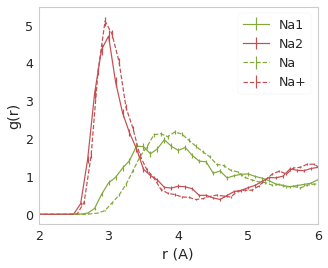

In [16]:
# plotting g(r) for each Na+
plt.figure(figsize=(5,4))
plt.errorbar(gr_loc[:,0], gr_loc[:,1], gr_loc[:,3], color='g', label='Na1')
plt.errorbar(gr_loc[:,0], gr_loc[:,2], gr_loc[:,4], color='r', label='Na2')
plt.errorbar(neutral_rdf[:,0], neutral_rdf[:,1], yerr=neutral_rdf[:,2], color='g', linestyle='--', label='Na')
plt.errorbar(cation_rdf[:,0], cation_rdf[:,1], yerr=cation_rdf[:,2], color='r', linestyle='--', label='Na+')
plt.xlim([2,6])
plt.legend(loc=1)
plt.xlabel('r (A)')
plt.ylabel('g(r)')

plt.grid(False)

In [ ]:
# OBSOLETE 

In [10]:
# na_fc_ee = np.load('solvent_environments/fes_eqb_na_fc.npy')
# ar_fc_ee = np.load('solvent_environments/fes_eqb_ar_fc.npy')

# na_cage_ee = np.load('solvent_environments/fes_eqb_na4-5.npy')
# ar_cage_ee = np.load('solvent_environments/fes_eqb_ar4-5.npy')

# na_loc_ee = np.load('solvent_environments/fes_eqb_na6-7.npy')
# ar_loc_ee = np.load('solvent_environments/fes_eqb_ar6-7.npy')

In [11]:
# # counting number of Ar in the intramolecular region for ranges [3.6, 7.5], [4.0, 5.0], [6.0, 7.0]
# r_cutoff = 3.0; kappa = 10

# counts_intra_fc = np.zeros(len(na_fc_ee))
# for i in range(len(na_fc_ee)):
#     closest_Ar = lib.closestAr(na_fc_ee[i], ar_fc_ee[i], n_cutoff=20, option='dimer') - na_fc_ee[i,0,:]
#     bond_ax = na_fc_ee[i,1,:] - na_fc_ee[i,0,:]
#     bond_dist = np.sqrt(np.dot(bond_ax, bond_ax))
#     bond_ax /= bond_dist
    
#     axial_dist = np.dot(closest_Ar, bond_ax)
#     radial_dist = np.sqrt(np.dot(closest_Ar, closest_Ar.T).diagonal() - axial_dist**2)
    
#     radial_filter = 1/(np.exp(kappa*(radial_dist - r_cutoff)) + 1)
#     axial_filter = 1/(np.exp(kappa*(np.abs(axial_dist-0.5*bond_dist)-0.5*bond_dist)) + 1)
    
#     counts_intra_fc[i] = np.dot(radial_filter, axial_filter)

# counts_intra_cage = np.zeros(len(na_cage_ee))
# for i in range(len(na_cage_ee)):
#     closest_Ar = lib.closestAr(na_cage_ee[i], ar_cage_ee[i], n_cutoff=20, option='dimer') - na_cage_ee[i,0,:]
#     bond_ax = na_cage_ee[i,1,:] - na_cage_ee[i,0,:]
#     bond_dist = np.sqrt(np.dot(bond_ax, bond_ax))
#     bond_ax /= bond_dist
    
#     axial_dist = np.dot(closest_Ar, bond_ax)
#     radial_dist = np.sqrt(np.dot(closest_Ar, closest_Ar.T).diagonal() - axial_dist**2)
    
#     radial_filter = 1/(np.exp(kappa*(radial_dist - r_cutoff)) + 1)
#     axial_filter = 1/(np.exp(kappa*(np.abs(axial_dist-0.5*bond_dist)-0.5*bond_dist)) + 1)
    
#     counts_intra_cage[i] = np.dot(radial_filter, axial_filter)
    
# counts_intra_loc = np.zeros(len(na_loc_ee))
# for i in range(len(na_loc_ee)):
#     closest_Ar = lib.closestAr(na_loc_ee[i], ar_loc_ee[i], n_cutoff=20, option='dimer') - na_loc_ee[i,0,:]
#     bond_ax = na_loc_ee[i,1,:] - na_loc_ee[i,0,:]
#     bond_dist = np.sqrt(np.dot(bond_ax, bond_ax))
#     bond_ax /= bond_dist
    
#     axial_dist = np.dot(closest_Ar, bond_ax)
#     radial_dist = np.sqrt(np.dot(closest_Ar, closest_Ar.T).diagonal() - axial_dist**2)
    
#     radial_filter = 1/(np.exp(kappa*(radial_dist - r_cutoff)) + 1)
#     axial_filter = 1/(np.exp(kappa*(np.abs(axial_dist-0.5*bond_dist)-0.5*bond_dist)) + 1)
    
#     counts_intra_loc[i] = np.dot(radial_filter, axial_filter)

3824.0
991.0
1000.0
2.7694822175732217 2.697906155398587


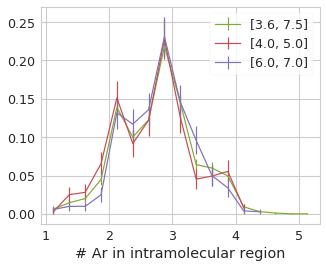

In [12]:
# # integrate over cylinder r_cutoff = 3.0; kappa = 10
# distr_intra_fc_ee = genDistr(counts_intra_fc, spacing=0.25)
# distr_intra_cage_ee = genDistr(counts_intra_cage, spacing=0.25)
# distr_intra_loc_ee = genDistr(counts_intra_loc, spacing=0.25)

# plt.figure(figsize=(5,4))
# plt.errorbar(distr_intra_fc_ee[:,0], distr_intra_fc_ee[:,1], yerr=distr_intra_fc_ee[:,2], color='C1', label='[3.6, 7.5]')
# plt.errorbar(distr_intra_cage_ee[:,0], distr_intra_cage_ee[:,1], yerr=distr_intra_cage_ee[:,2], color='C2', label='[4.0, 5.0]')
# plt.errorbar(distr_intra_loc_ee[:,0], distr_intra_loc_ee[:,1], yerr=distr_intra_loc_ee[:,2], color='C3', label='[6.0, 7.0]')
# plt.legend(loc=1)
# plt.xlabel('# Ar in intramolecular region')
# print(np.dot(distr_intra_fc_ee[:,0], distr_intra_fc_ee[:,1]), np.dot(distr_intra_cage_ee[:,0], distr_intra_cage_ee[:,1]))

In [ ]:
# DEFINING 4 REGIMES, [3.6, 5.8], [5.8, 6.9], [6.9, 7.6], [7.6, 9.0], AND CHARACTERIZING WITH ELLIPTICAL RDF

In [17]:
# loading na, ar positions for ranges [3.6, 5.8], [5.8, 6.9], [6.9, 7.6], [7.6, 9.0]
na1 = np.load('/media/andy/Samsung_T5/supermic/analysis/Na2+_Ar/solvent_environments/fes_eqb_na36-58.npy')
ar1 = np.load('/media/andy/Samsung_T5/supermic/analysis/Na2+_Ar/solvent_environments/fes_eqb_ar36-58.npy')
e_com1 = np.load('/media/andy/Samsung_T5/supermic/analysis/Na2+_Ar/solvent_environments/fes_eqb_ecom36-58.npy')

na2 = np.load('/media/andy/Samsung_T5/supermic/analysis/Na2+_Ar/solvent_environments/fes_eqb_na58-69.npy')
ar2 = np.load('/media/andy/Samsung_T5/supermic/analysis/Na2+_Ar/solvent_environments/fes_eqb_ar58-69.npy')
e_com2 = np.load('/media/andy/Samsung_T5/supermic/analysis/Na2+_Ar/solvent_environments/fes_eqb_ecom58-69.npy')

na3 = np.load('/media/andy/Samsung_T5/supermic/analysis/Na2+_Ar/solvent_environments/fes_eqb_na69-76.npy')
ar3 = np.load('/media/andy/Samsung_T5/supermic/analysis/Na2+_Ar/solvent_environments/fes_eqb_ar69-76.npy')
e_com3 = np.load('/media/andy/Samsung_T5/supermic/analysis/Na2+_Ar/solvent_environments/fes_eqb_ecom69-76.npy')

na4 = np.load('/media/andy/Samsung_T5/supermic/analysis/Na2+_Ar/solvent_environments/fes_eqb_na76-90.npy')
ar4 = np.load('/media/andy/Samsung_T5/supermic/analysis/Na2+_Ar/solvent_environments/fes_eqb_ar76-90.npy')
e_com4 = np.load('/media/andy/Samsung_T5/supermic/analysis/Na2+_Ar/solvent_environments/fes_eqb_ecom76-90.npy')

In [18]:
def ellipticalRDF(r_Na, r_Ar, avg_bond_length, r, r0, dr):
    bins = np.arange(r0,r+dr,dr)
    elliptical_rdf = np.zeros([len(bins),3])
    raw_counts = np.zeros(len(bins))

    for i in range(len(r_Na)):
        r_na1_ar = r_Ar[i] - np.repeat([r_Na[i,0]], repeats=1600, axis=0)
        r_na2_ar = r_Ar[i] - np.repeat([r_Na[i,1]], repeats=1600, axis=0)
        bond_dist = lib.dist(r_Na[i,0], r_Na[i,1])
        dimer_dist = np.sqrt(np.sum(r_na1_ar**2, axis=1)) + np.sqrt(np.sum(r_na2_ar**2, axis=1)) - bond_dist

        for j in range(len(dimer_dist)):
            if dimer_dist[j] < r+dr and dimer_dist[j] > r0:
                my_ind = int((dimer_dist[j]-r0)/dr)
                dV = 4*np.pi/27*(((my_ind+1)*dr+bond_dist)**3 - (my_ind*dr+bond_dist)**3)
                elliptical_rdf[my_ind, 1] += 1/dV
                raw_counts[my_ind] += 1

    elliptical_rdf[:,2] = np.sqrt(raw_counts)
    for i in range(len(bins)):
        deltaV = 4*np.pi/27*((bins[i]+dr+avg_bond_length)**3 - (bins[i]+avg_bond_length)**3)
        elliptical_rdf[i,2] /= deltaV
    rho = 1600/(43.8332180561224**3)
    elliptical_rdf /= len(r_Na)*rho
    raw_counts /= len(r_Na)
    elliptical_rdf[:,0] = bins
    
    return elliptical_rdf, raw_counts

In [19]:
elliptical_rdf1, raw_counts1 = ellipticalRDF(na1, ar1, 4.7, 6, 0, 0.25)
elliptical_rdf2, raw_counts2 = ellipticalRDF(na2, ar2, 6.35, 6, 0, 0.25)
elliptical_rdf3, raw_counts3 = ellipticalRDF(na3, ar3, 7.25, 6, 0, 0.25)
elliptical_rdf4, raw_counts4 = ellipticalRDF(na4, ar4, 8.3, 6, 0, 0.25)

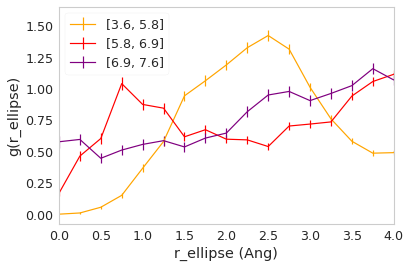

In [20]:
#comparing elliptical g(r)
plt.errorbar(elliptical_rdf1[:,0], elliptical_rdf1[:,1], yerr=elliptical_rdf1[:,2], color='orange', label='[3.6, 5.8]')
plt.errorbar(elliptical_rdf2[:,0], elliptical_rdf2[:,1], yerr=elliptical_rdf2[:,2], color='red', label='[5.8, 6.9]')
plt.errorbar(elliptical_rdf3[:,0], elliptical_rdf3[:,1], yerr=elliptical_rdf3[:,2], color='purple', label='[6.9, 7.6]')
# plt.errorbar(elliptical_rdf4[:,0], elliptical_rdf4[:,1], yerr=elliptical_rdf4[:,2], color='C4', label='[7.6, 9.0]')

plt.xlim([0, 4])
plt.legend(loc=2)
plt.xlabel('r_ellipse (Ang)')
plt.ylabel('g(r_ellipse)')
plt.grid(False)
# plt.savefig('fes_elliptical_rdf.eps', format='eps')

In [21]:
na_fc_ne = np.load('solvent_environments/non_eqb_na_fc.npy')
ar_fc_ne = np.load('solvent_environments/non_eqb_ar_fc.npy')

na_cage_ne = np.load('solvent_environments/non_eqb_na_cage.npy')
ar_cage_ne = np.load('solvent_environments/non_eqb_ar_cage.npy')

In [22]:
# counting number of Ar in the intramolecular region for ranges [3.6, 6.0], [6.0, 7.0]
r_cutoff = 3.0; kappa = 10

counts_intra_fc_ne = np.zeros(len(na_fc_ne))
for i in range(len(na_fc_ne)):
    closest_Ar = lib.closestAr(na_fc_ne[i], ar_fc_ne[i], n_cutoff=20, option='dimer') - na_fc_ne[i,0,:]
    bond_ax = na_fc_ne[i,1,:] - na_fc_ne[i,0,:]
    bond_dist = np.sqrt(np.dot(bond_ax, bond_ax))
    bond_ax /= bond_dist
    
    axial_dist = np.dot(closest_Ar, bond_ax)
    radial_dist = np.sqrt(np.dot(closest_Ar, closest_Ar.T).diagonal() - axial_dist**2)
    
    radial_filter = 1/(np.exp(kappa*(radial_dist - r_cutoff)) + 1)
    axial_filter = 1/(np.exp(kappa*(np.abs(axial_dist-0.5*bond_dist)-0.5*bond_dist)) + 1)
#    axial_filter = 1/(np.exp(kappa*(np.abs(axial_dist-0.5*bond_dist)-1.8)) + 1)
    
    counts_intra_fc_ne[i] = np.dot(radial_filter, axial_filter)

counts_intra_cage_ne = np.zeros(len(na_cage_ne))
for i in range(len(na_cage_ne)):
    closest_Ar = lib.closestAr(na_cage_ne[i], ar_cage_ne[i], n_cutoff=20, option='dimer') - na_cage_ne[i,0,:]
    bond_ax = na_cage_ne[i,1,:] - na_cage_ne[i,0,:]
    bond_dist = np.sqrt(np.dot(bond_ax, bond_ax))
    bond_ax /= bond_dist
    
    axial_dist = np.dot(closest_Ar, bond_ax)
    radial_dist = np.sqrt(np.dot(closest_Ar, closest_Ar.T).diagonal() - axial_dist**2)
    
    radial_filter = 1/(np.exp(kappa*(radial_dist - r_cutoff)) + 1)
    axial_filter = 1/(np.exp(kappa*(np.abs(axial_dist-0.5*bond_dist)-0.5*bond_dist)) + 1)
#    axial_filter = 1/(np.exp(kappa*(np.abs(axial_dist-0.5*bond_dist)-1.8)) + 1)
    
    counts_intra_cage_ne[i] = np.dot(radial_filter, axial_filter)

2840.0
1716.0
0.8619718309859155 1.6368006993006996


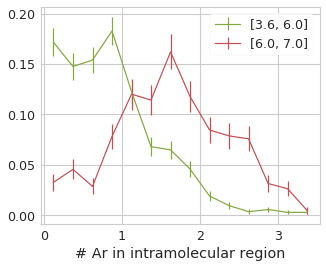

In [23]:
# integrate over cylinder r_cutoff = 3.0; kappa = 10
distr_intra_fc_ne = genDistr(counts_intra_fc_ne, spacing=0.25)
distr_intra_cage_ne = genDistr(counts_intra_cage_ne, spacing=0.25)

plt.figure(figsize=(5,4))
plt.errorbar(distr_intra_fc_ne[:,0], distr_intra_fc_ne[:,1], yerr=distr_intra_fc_ne[:,2], color='C1', label='[3.6, 6.0]')
plt.errorbar(distr_intra_cage_ne[:,0], distr_intra_cage_ne[:,1], yerr=distr_intra_cage_ne[:,2], color='C2', label='[6.0, 7.0]')
# plt.errorbar(distr_intra_loc[:,0], distr_intra_loc[:,1], yerr=distr_intra_loc[:,2], color='C3', label='[7.0, 9.0]')
plt.legend(loc=1)
plt.xlabel('# Ar in intramolecular region')
print(np.dot(distr_intra_fc_ne[:,0], distr_intra_fc_ne[:,1]), np.dot(distr_intra_cage_ne[:,0], distr_intra_cage_ne[:,1]))

In [7]:
# Ar moving along bond-axis
my_dir = '/media/andy/Samsung_T5/supermic/Na2+_1Ar/3.6/axial/x/'
t0 = 0; t = 800; dt = 20

t_frames = np.arange(t0, t+dt, dt)
r_Ar = np.zeros([len(t_frames), 3]); r_Na = np.zeros([len(t_frames), 2, 3])
for i in range(len(t_frames)):
    r_Ar[i] = lib.readAr(my_dir+'/out.water', t_frames[i])
    r_Na[i] = lib.readNa(my_dir+'/out.na', t_frames[i])

dist_Ar_Na = np.array([t_frames, [lib.dist(r_Ar[i], r_Na[i,0]) for i in range(len(t_frames))]]).T
eigvals = lib.readEigval(my_dir, nstates=2)[:205:5]

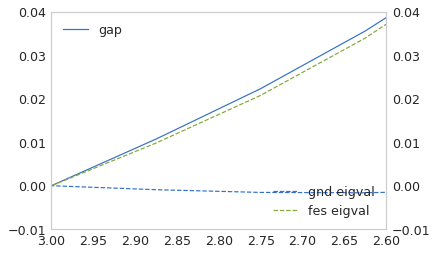

In [11]:
# Energy gap as 1 Ar moves along bond axis
plt.plot(dist_Ar_Na[:,1], eigvals[:,2]-eigvals[:,1] - eigvals[16,2]+eigvals[16,1], label='gap')
plt.legend(loc=2, framealpha=0.0)
plt.ylim([-0.01, 0.04])
plt.grid(False)
plt.twinx()
plt.plot(dist_Ar_Na[:,1], eigvals[:,1]-eigvals[16,1], '--', label='gnd eigval')
plt.plot(dist_Ar_Na[:,1], eigvals[:,2]-eigvals[16,2], '--', label='fes eigval')
plt.grid(False)
plt.ylim([-0.01,0.04])
plt.xlim([3.0, 2.6])
plt.legend(loc=4, framealpha=0.0)

(-0.01, 0.04)

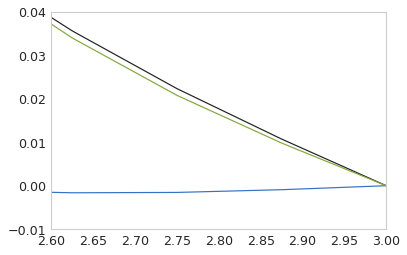

In [19]:
plt.plot(dist_Ar_Na[:,1], eigvals[:,2]-eigvals[:,1] - eigvals[16,2]+eigvals[16,1], label='gap', color='k')
#lt.grid(False)
#lt.twinx()
plt.plot(dist_Ar_Na[:,1], eigvals[:,1] - eigvals[16,1])
plt.plot(dist_Ar_Na[:,1], eigvals[:,2] - eigvals[16,2])

plt.grid(False)
plt.xlim([2.6, 3])
plt.ylim([-0.01,0.04])

In [9]:
# Ar moving parallel to bond-axis
my_dir = '/media/andy/Samsung_T5/supermic/Na2+_1Ar/3.6/parallel/x/'
t0 = 0; t = 800; dt = 20

t_frames = np.arange(t0, t+dt, dt)
r_Ar = np.zeros([len(t_frames), 3]); r_Na = np.zeros([len(t_frames), 2, 3])
for i in range(len(t_frames)):
    r_Ar[i] = lib.readAr(my_dir+'/out.water', t_frames[i])
    r_Na[i] = lib.readNa(my_dir+'/out.na', t_frames[i])

dist_Ar_Na_par = np.array([t_frames, r_Ar[:,0]]).T
eigvals_par = lib.readEigval(my_dir, nstates=2)[:205:5]

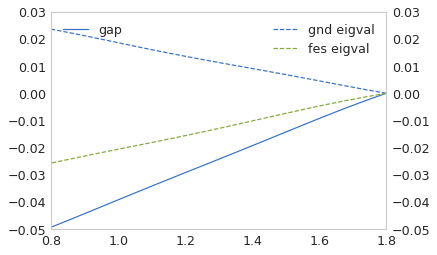

In [10]:
# Energy gap as 1 Ar moves parallel to bond axis
plt.plot(dist_Ar_Na_par[:,1], eigvals_par[:,2]-eigvals_par[:,1] - eigvals_par[0,2]+eigvals_par[0,1], label='gap')
plt.legend(loc=2, framealpha=0.0)
plt.ylim([-0.05, 0.03])
plt.grid(False)
plt.twinx()
plt.plot(dist_Ar_Na_par[:,1], eigvals_par[:,1]-eigvals_par[0,1], '--', label='gnd eigval')
plt.plot(dist_Ar_Na_par[:,1], eigvals_par[:,2]-eigvals_par[0,2], '--', label='fes eigval')
plt.grid(False)
plt.ylim([-0.05, 0.03])
plt.xlim([0.8, 1.8])
plt.legend(loc=1, framealpha=0.0)

(0.8, 1.8)

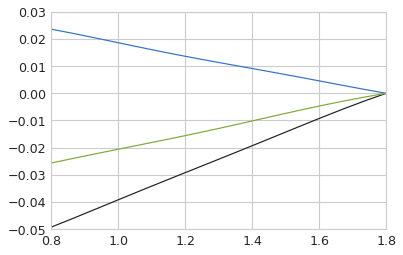

In [22]:
plt.plot(dist_Ar_Na_par[:,1], eigvals_par[:,2]-eigvals_par[:,1] - eigvals_par[0,2]+eigvals_par[0,1], color='k')
plt.plot(dist_Ar_Na_par[:,1], eigvals_par[:,1]-eigvals_par[0,1])
plt.plot(dist_Ar_Na_par[:,1], eigvals_par[:,2]-eigvals_par[0,2])

plt.ylim([-0.05, 0.03])
plt.xlim([0.8, 1.8])

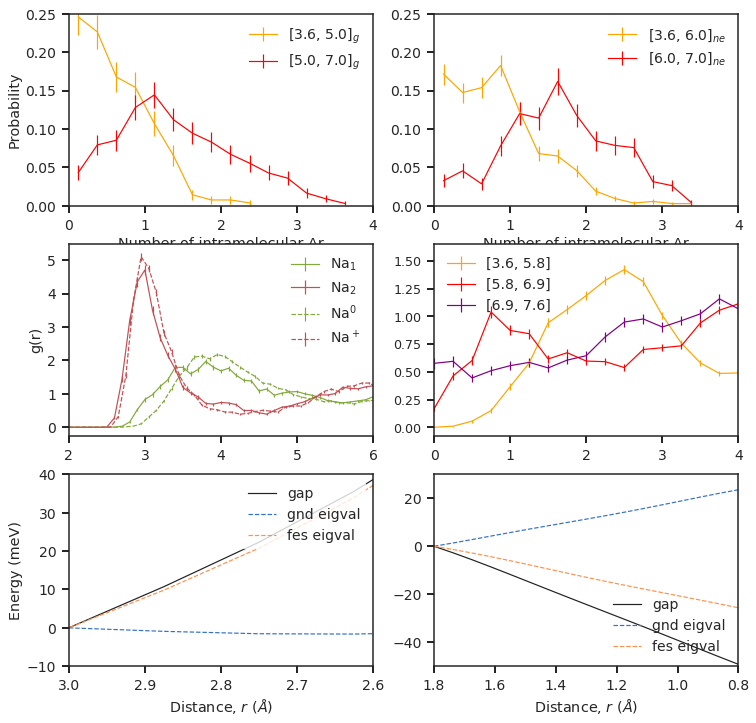

In [24]:
# 6-panel roughly publication quality
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12,12))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

ax1.errorbar(distr_intra1[:,0], distr_intra1[:,1], yerr=distr_intra1[:,2], color='orange', label='[3.6, 5.0]$_g$')
ax1.errorbar(distr_intra2[:,0], distr_intra2[:,1], yerr=distr_intra2[:,2], color='red', label='[5.0, 7.0]$_g$')
ax1.grid(False)
ax1.set_xlim([0,4])
ax1.set_ylim([0,0.25])
ax1.set_xlabel('Number of intramolecular Ar')
ax1.set_ylabel('Probability')
ax1.legend(loc=1, prop={"size":14}, edgecolor='white', framealpha=0.0)

ax2.errorbar(distr_intra_fc_ne[:,0], distr_intra_fc_ne[:,1], yerr=distr_intra_fc_ne[:,2], color='orange', label='[3.6, 6.0]$_{ne}$')
ax2.errorbar(distr_intra_cage_ne[:,0], distr_intra_cage_ne[:,1], yerr=distr_intra_cage_ne[:,2], color='red', label='[6.0, 7.0]$_{ne}$')
ax2.grid(False)
ax2.set_xlim([0,4])
ax2.set_ylim([0,0.25])
ax2.set_xlabel('Number of intramolecular Ar')
ax2.legend(loc=1, prop={"size":14}, edgecolor='white')

ax3.errorbar(gr_loc[:,0], gr_loc[:,1], yerr=gr_loc[:,3], color='g', label='Na$_1$')
ax3.errorbar(gr_loc[:,0], gr_loc[:,2], yerr=gr_loc[:,4], color='r', label='Na$_2$')
ax3.errorbar(neutral_rdf[:,0], neutral_rdf[:,1], yerr=neutral_rdf[:,2], color='g', linestyle='--', label='Na$^0$')
ax3.errorbar(cation_rdf[:,0], cation_rdf[:,1], yerr=cation_rdf[:,2], color='r', linestyle='--', label='Na$^+$')
ax3.grid(False)
ax3.set_xlim([2,6])
ax3.set_ylabel('g(r)')
# ax3.set_xlabel('r_radial (Ang)')
ax3.legend(loc=1, prop={"size":14}, edgecolor='white')

ax4.errorbar(elliptical_rdf1[:,0], elliptical_rdf1[:,1], yerr=elliptical_rdf1[:,2], color='orange', label='[3.6, 5.8]')
ax4.errorbar(elliptical_rdf2[:,0], elliptical_rdf2[:,1], yerr=elliptical_rdf2[:,2], color='red', label='[5.8, 6.9]')
ax4.errorbar(elliptical_rdf3[:,0], elliptical_rdf3[:,1], yerr=elliptical_rdf3[:,2], color='purple', label='[6.9, 7.6]')
ax4.set_xlim([0, 4])
ax4.legend(loc=2, prop={"size":14}, edgecolor='white', framealpha=0.0)
# ax4.set_xlabel('r_ellipse (Ang)')
# ax4.set_ylabel('g(r_ellipse)')
ax4.grid(False)

# ax3.errorbar(distr_intra_fc_ee[:,0], distr_intra_fc_ee[:,1], yerr=distr_intra_fc_ee[:,2], color='red', label='[3.6, 7.5]$_e$')
# ax3.errorbar(distr_intra_cage_ee[:,0], distr_intra_cage_ee[:,1], yerr=distr_intra_cage_ee[:,2], color='orange', label='[4.0, 5.0]$_e$')
# ax3.errorbar(distr_intra_loc_ee[:,0], distr_intra_loc_ee[:,1], yerr=distr_intra_loc_ee[:,2], color='purple', label='[6.0, 7.0]$_e$')
# ax3.grid(False)
# ax3.set_xlim([1,4.5])
# ax3.set_ylim([0,0.25])
# ax3.legend(loc=1, prop={"size":14}, edgecolor='white', framealpha=0.0)

# plt.plot(dist_Ar_Na[:,1], eigvals[:,2]-eigvals[:,1] - eigvals[16,2]+eigvals[16,1], label='gap', color='k')
# plt.grid(False)
# plt.twinx()
# plt.plot(dist_Ar_Na[:,1], eigvals[:,1] - eigvals[16,1])
# plt.plot(dist_Ar_Na[:,1], eigvals[:,2] - eigvals[16,2])


ax5.plot(dist_Ar_Na[:,1], 1000*(eigvals[:,2]-eigvals[:,1]-eigvals[16,2]+eigvals[16,1]), color='k', label='gap')
ax5.set_ylim([-10, 40])
ax5.grid(False)
ax5.plot(dist_Ar_Na[:,1], 1000*(eigvals[:,1]-eigvals[16,1]), 'C0--', label='gnd eigval')
ax5.plot(dist_Ar_Na[:,1], 1000*(eigvals[:,2]-eigvals[16,2]), 'C4--', label='fes eigval')
ax5.legend(loc=1, framealpha=0.0, prop={"size":14})
ax5.set_ylabel('Energy (meV)')
ax5.set_xlim([3,2.6])
ax5.set_xlabel('Distance, $r$ ($\AA$)')
ax5.legend(loc=1, prop={"size":14}, edgecolor='white')

# plt.plot(dist_Ar_Na_par[:,1], eigvals_par[:,2]-eigvals_par[:,1] - eigvals_par[0,2]+eigvals_par[0,1], color='k')
# plt.plot(dist_Ar_Na_par[:,1], eigvals_par[:,1]-eigvals_par[0,1])
# plt.plot(dist_Ar_Na_par[:,1], eigvals_par[:,2]-eigvals_par[0,2])

# plt.ylim([-0.05, 0.03])
# plt.xlim([0.8, 1.8])

ax6.plot(dist_Ar_Na_par[:,1], 1000*(eigvals_par[:,2]-eigvals_par[:,1] - eigvals_par[0,2]+eigvals_par[0,1]), color='k', label='gap')
ax6.grid(False)
ax6.plot(dist_Ar_Na_par[:,1], 1000*(eigvals_par[:,1]-eigvals_par[0,1]), 'C0--', label='gnd eigval')
ax6.plot(dist_Ar_Na_par[:,1], 1000*(eigvals_par[:,2]-eigvals_par[0,2]), 'C4--', label='fes eigval')
ax6.legend(loc=4, framealpha=0.0, prop={"size":14})
# ax6.set_ylabel('Energy (meV)')
ax6.set_ylim([-50,30])
ax6.set_xlim([1.8, 0.8])
ax6.set_xlabel('Distance, $r$ ($\AA$)')

# fig.text(0.06, 0.5, 'Probability', ha='center', va='center', rotation='vertical', fontname='sans-serif', size=16)

ax1.tick_params(which='major', length=7, width=2)
ax1.tick_params(axis='x', labelsize=14)
ax1.tick_params(axis='y', labelsize=14)
ax2.tick_params(which='major', length=7, width=2)
ax2.tick_params(axis='x', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)
ax3.tick_params(which='major', length=7, width=2)
ax3.tick_params(axis='x', labelsize=14)
ax3.tick_params(axis='y', labelsize=14)
ax4.tick_params(which='major', length=7, width=2)
ax4.tick_params(axis='x', labelsize=14)
ax5.tick_params(axis='y', labelsize=14)
ax5.tick_params(which='major', length=7, width=2)
ax5.tick_params(axis='x', labelsize=14)
ax5.tick_params(axis='y', labelsize=14)
ax6.tick_params(which='major', length=7, width=2)
ax6.tick_params(axis='x', labelsize=14)
ax6.tick_params(axis='y', labelsize=14)

ax1.spines['top'].set_linewidth(1.5)
ax1.spines['top'].set_color('k')
ax1.spines['bottom'].set_linewidth(1.5)
ax1.spines['bottom'].set_color('k')
ax1.spines['left'].set_linewidth(1.5)
ax1.spines['left'].set_color('k')
ax1.spines['right'].set_linewidth(1.5)
ax1.spines['right'].set_color('k')
ax2.spines['top'].set_linewidth(1.5)
ax2.spines['top'].set_color('k')
ax2.spines['bottom'].set_linewidth(1.5)
ax2.spines['bottom'].set_color('k')
ax2.spines['left'].set_linewidth(1.5)
ax2.spines['left'].set_color('k')
ax2.spines['right'].set_linewidth(1.5)
ax2.spines['right'].set_color('k')
ax3.spines['top'].set_linewidth(1.5)
ax3.spines['top'].set_color('k')
ax3.spines['bottom'].set_linewidth(1.5)
ax3.spines['bottom'].set_color('k')
ax3.spines['left'].set_linewidth(1.5)
ax3.spines['left'].set_color('k')
ax3.spines['right'].set_linewidth(1.5)
ax3.spines['right'].set_color('k')
ax4.spines['top'].set_linewidth(1.5)
ax4.spines['top'].set_color('k')
ax4.spines['bottom'].set_linewidth(1.5)
ax4.spines['bottom'].set_color('k')
ax4.spines['left'].set_linewidth(1.5)
ax4.spines['left'].set_color('k')
ax4.spines['right'].set_linewidth(1.5)
ax4.spines['right'].set_color('k')
ax5.spines['top'].set_linewidth(1.5)
ax5.spines['top'].set_color('k')
ax5.spines['bottom'].set_linewidth(1.5)
ax5.spines['bottom'].set_color('k')
ax5.spines['left'].set_linewidth(1.5)
ax5.spines['left'].set_color('k')
ax5.spines['right'].set_linewidth(1.5)
ax5.spines['right'].set_color('k')
ax6.spines['top'].set_linewidth(1.5)
ax6.spines['top'].set_color('k')
ax6.spines['bottom'].set_linewidth(1.5)
ax6.spines['bottom'].set_color('k')
ax6.spines['left'].set_linewidth(1.5)
ax6.spines['left'].set_color('k')
ax6.spines['right'].set_linewidth(1.5)
ax6.spines['right'].set_color('k')

plt.savefig('6panel_structure.eps', format='eps')

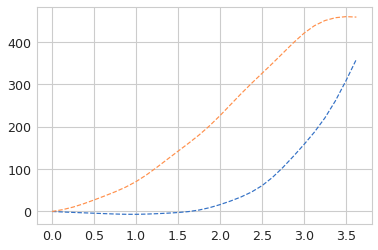

In [22]:
plt.plot(dist_Ar_Na[11:,1][::-1], 1000*(eigvals[11:,2]-eigvals[11:,1]-eigvals[11,2]+eigvals[11,1]), color='k', label='gap')
plt.plot(dist_Ar_Na[11:,1][::-1], 1000*(eigvals[11:,1]-eigvals[11,1]), 'C0--', label='gnd eigval')
plt.plot(dist_Ar_Na[11:,1][::-1], 1000*(eigvals[11:,2]-eigvals[11,2]), 'C4--', label='fes eigval')